In [127]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [128]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [129]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [130]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [131]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [132]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [133]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [134]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [135]:
master_data = master_data[132:]

In [136]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [137]:
master_data.reset_index(inplace=True)

In [138]:
master_data = master_data.drop(labels='index', axis=1)

In [139]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [140]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [141]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [142]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [143]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [144]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [145]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [146]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [147]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [148]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [149]:
master_data.to_csv('master_data.csv')

In [150]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

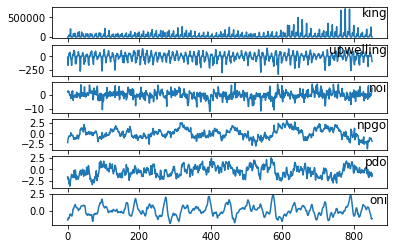

In [151]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [152]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [153]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [154]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [155]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
1/1 - 14s - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2181
Epoch 2/1000
1/1 - 0s - loss: 0.0109 - root_mean_squared_error: 0.1044 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2155
Epoch 3/1000
1/1 - 0s - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0454 - val_root_mean_squared_error: 0.2130
Epoch 4/1000
1/1 - 0s - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2107
Epoch 5/1000
1/1 - 0s - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2087
Epoch 6/1000
1/1 - 0s - loss: 0.0095 - root_mean_squared_error: 0.0976 - val_loss: 0.0428 - val_root_mean_squared_error: 0.2069
Epoch 7/1000
1/1 - 0s - loss: 0.0094 - root_mean_squared_error: 0.0968 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2055
Epoch 8/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0418 - val_root_me

Epoch 40/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 41/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2050
Epoch 42/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2049
Epoch 43/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2048
Epoch 44/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2047
Epoch 45/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0418 - val_root_mean_squared_error: 0.2046
Epoch 46/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0418 - val_root_mean_squared_error: 0.2044
Epoch 47/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0418 - val_

Epoch 79/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 80/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 81/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 82/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 83/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 84/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 85/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 86/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0417 - val_

Epoch 118/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941
Epoch 119/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1938
Epoch 120/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1925
Epoch 121/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1930
Epoch 122/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0886 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1911
Epoch 123/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1917
Epoch 124/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1913
Epoch 125/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.036

Epoch 157/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1882
Epoch 158/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1881
Epoch 159/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1881
Epoch 160/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1881
Epoch 161/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1880
Epoch 162/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1880
Epoch 163/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1880
Epoch 164/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.035

Epoch 196/1000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1822
Epoch 197/1000
1/1 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1818
Epoch 198/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1814
Epoch 199/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1811
Epoch 200/1000
1/1 - 0s - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1807
Epoch 201/1000
1/1 - 0s - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1804
Epoch 202/1000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1800
Epoch 203/1000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.032

Epoch 235/1000
1/1 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1680
Epoch 236/1000
1/1 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1678
Epoch 237/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1672
Epoch 238/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1670
Epoch 239/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1668
Epoch 240/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1660
Epoch 241/1000
1/1 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1659
Epoch 242/1000
1/1 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.027

Epoch 274/1000
1/1 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1535
Epoch 275/1000
1/1 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 276/1000
1/1 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541
Epoch 277/1000
1/1 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1525
Epoch 278/1000
1/1 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1539
Epoch 279/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0652 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1524
Epoch 280/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1530
Epoch 281/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.023

Epoch 313/1000
1/1 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1461
Epoch 314/1000
1/1 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1460
Epoch 315/1000
1/1 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1489
Epoch 316/1000
1/1 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1464
Epoch 317/1000
1/1 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1451
Epoch 318/1000
1/1 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1474
Epoch 319/1000
1/1 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1466
Epoch 320/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.020

Epoch 352/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1383
Epoch 353/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1398
Epoch 354/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 355/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1382
Epoch 356/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 357/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1374
Epoch 358/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1398
Epoch 359/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.018

Epoch 391/1000
1/1 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1334
Epoch 392/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 393/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322
Epoch 394/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1335
Epoch 395/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 396/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1311
Epoch 397/1000
1/1 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1330
Epoch 398/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.017

Epoch 430/1000
1/1 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 431/1000
1/1 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1266
Epoch 432/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1264
Epoch 433/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1267
Epoch 434/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 435/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 436/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1261
Epoch 437/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.015

Epoch 469/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 470/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 471/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 472/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1206
Epoch 473/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 474/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 475/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 476/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.014

Epoch 508/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 509/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 510/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 511/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 512/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 513/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 514/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 515/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.013

Epoch 547/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 548/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 549/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 550/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 551/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 552/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 553/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0495 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 554/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.011

Epoch 586/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 587/1000
1/1 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 588/1000
1/1 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 589/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 590/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 591/1000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 592/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 593/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.010

Epoch 625/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 626/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0967
Epoch 627/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0967
Epoch 628/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 629/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0964
Epoch 630/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0962
Epoch 631/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 632/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.009

Epoch 664/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 665/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 666/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0914
Epoch 667/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0913
Epoch 668/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911
Epoch 669/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 670/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 671/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.008

Epoch 703/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 704/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 705/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0458 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 706/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 707/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 708/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 709/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 710/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.007

Epoch 742/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827
Epoch 743/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 744/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 745/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824
Epoch 746/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823
Epoch 747/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 748/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820
Epoch 749/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.006

Epoch 781/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 782/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 783/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 784/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 785/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 786/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791
Epoch 787/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0797
Epoch 788/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.006

Epoch 820/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 821/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 822/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0418 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 823/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 824/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0758
Epoch 825/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 826/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 827/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.005

Epoch 859/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 860/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 861/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 862/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 863/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0741
Epoch 864/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0740
Epoch 865/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0742
Epoch 866/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.005

Epoch 898/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715
Epoch 899/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 900/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 901/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 902/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 903/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 904/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 905/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.005

Epoch 937/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695
Epoch 938/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 939/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695
Epoch 940/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 941/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 942/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 943/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 944/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.004

Epoch 976/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 977/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 978/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 979/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0403 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 980/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 981/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690
Epoch 982/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 983/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0406 - val_loss: 0.004

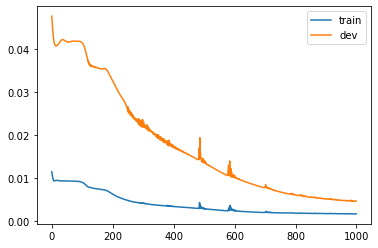

In [156]:
# design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=1000, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [157]:
# make a prediction
yhat = model.predict(test_X)
train_yhat = model.predict(train_X)

In [158]:
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))
train_X = train_X.reshape((train_X.shape[0], n_months*n_features))

In [159]:
# invert scaling for forecast
inv_yhat_train = concatenate((train_yhat, train_X[:, -5:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, -5:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [160]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [161]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

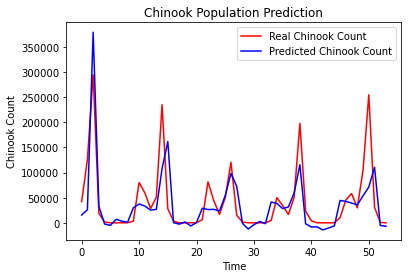

The test root mean squared error is 46821.8670281312.


In [162]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

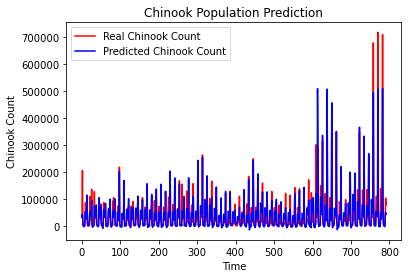

The test root mean squared error is 28662.783116787527.


In [163]:
plot_predictions(inv_y_train, inv_yhat_train)
return_rmse(inv_y_train, inv_yhat_train)

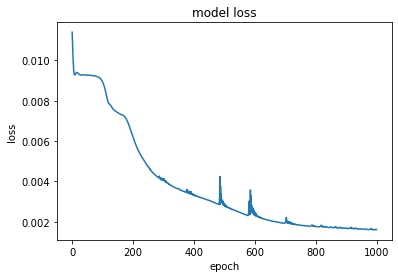

In [164]:
plot_loss(history)

In [165]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  431686
1  313752
2  294203
3  355503
    Count
0  488981
1  336030
2  381773
3  535746


In [166]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [167]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [168]:
return_rmse(actual, preds)

The test root mean squared error is 104803.47114719055.
